In [1]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Use below for charts in dark jupyter theme
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"} 
plt.rcParams.update(params)

import xai
import xai.data

In [2]:
csv_path = 'data/adult.data'
categorical_cols = ["gender", "workclass", "education", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "native-country", "loan"]
csv_columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "gender", "capital-gain", "capital-loss",
                   "hours-per-week", "native-country", "loan"]

In [3]:
df = xai.data.load_census()
df.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week,loan
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,<=50K


In [4]:
df = pd.read_csv(csv_path, names=csv_columns)
del df["fnlwgt"]
del df["native-country"]
df.head()
df.to_csv("../xai/data/census.csv")

In [5]:
target = "loan"
protected = ["ethnicity", "gender", "age"]

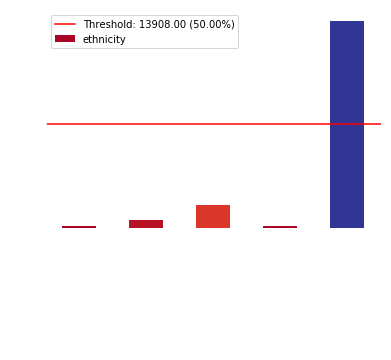

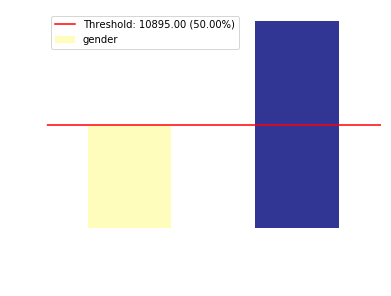

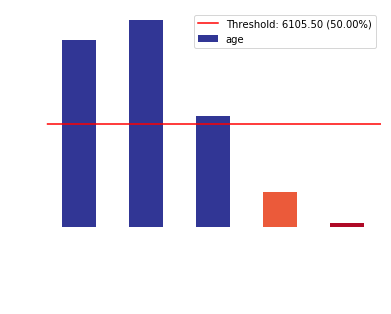

In [6]:
ims = xai.show_imbalances(df, protected)

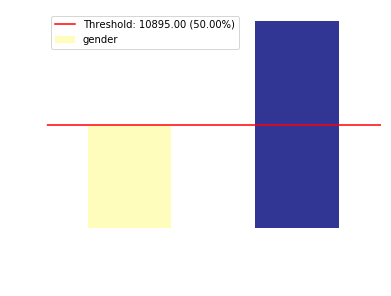

In [7]:
im = xai.show_imbalance(df, "gender")

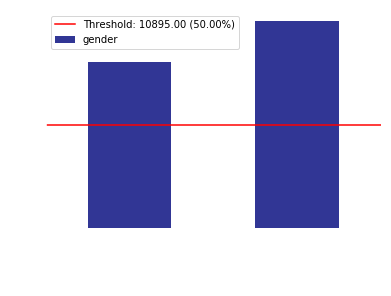

In [8]:
bal_df = xai.balance(df, "gender", upsample=0.8)

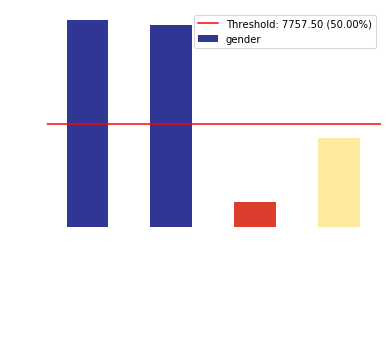

In [9]:
im = xai.show_imbalance(bal_df, "gender", cross=["loan"])

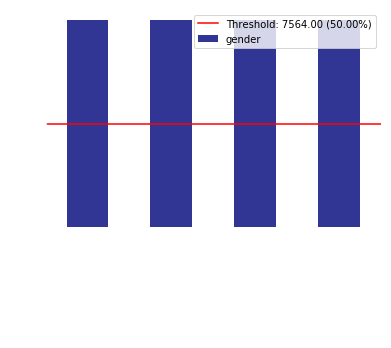

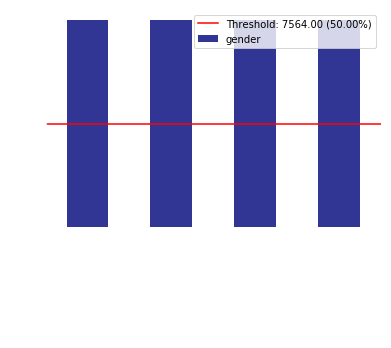

In [10]:
bal_df = xai.balance(df, "gender", cross=["loan"], upsample=1)
im = xai.show_imbalance(bal_df, "gender", cross=["loan"])

In [11]:

proc_df = xai.normalize_numeric(bal_df)
proc_df = xai.convert_categories(proc_df)
x = proc_df.drop("loan", axis=1)
y = proc_df["loan"]

x_train, y_train, x_test, y_test = xai.balanced_train_test_split(
            x, y, cross=["gender"], 
            categorical_cols=categorical_cols, min_per_class=300,
            fallback_type="half")

print(x_test.shape)

(1200, 12)


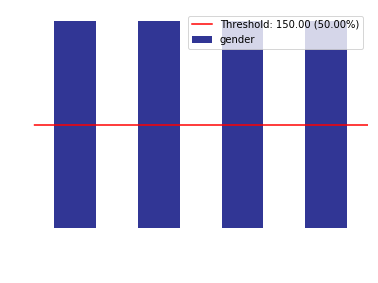

In [12]:
df_test = x_test.copy()
df_test["loan"] = y_test

_= xai.show_imbalance(df_test, "gender", cross=["loan"], categorical_cols=categorical_cols)

In [13]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, roc_curve, auc

from keras.layers import Input, Dense, Flatten, \
    Concatenate, concatenate, Dropout, Lambda
from keras.models import Model, Sequential
from keras.layers.embeddings import Embedding

def build_model(X):
    input_els = []
    encoded_els = []
    dtypes = list(zip(X.dtypes.index, map(str, X.dtypes)))
    for k,dtype in dtypes:
        input_els.append(Input(shape=(1,)))
        if dtype == "int8":
            e = Flatten()(Embedding(X[k].max()+1, 1)(input_els[-1]))
        else:
            e = input_els[-1]
        encoded_els.append(e)
    encoded_els = concatenate(encoded_els)

    layer1 = Dropout(0.5)(Dense(100, activation="relu")(encoded_els))
    out = Dense(1, activation='sigmoid')(layer1)

    # train model
    model = Model(inputs=input_els, outputs=[out])
    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
    return model


def f_in(X, m=None):
    """Preprocess input so it can be provided to a function"""
    if m:
        return [X.iloc[:m,i] for i in range(X.shape[1])]
    else:
        return [X.iloc[:,i] for i in range(X.shape[1])]

def f_out(probs, threshold=0.5):
    """Convert probabilities into classes"""
    return list((probs >= threshold).astype(int).T[0])


Using TensorFlow backend.


In [14]:
model = build_model(proc_df.drop("loan", axis=1))

model.fit(f_in(x_train), y_train, epochs=50, batch_size=512)

Epoch 1/50
59312/59312 [==============================] - 1s 10us/step - loss: 0.5508 - acc: 0.7170
Epoch 2/50
59312/59312 [==============================] - 0s 4us/step - loss: 0.4199 - acc: 0.8065
Epoch 3/50
59312/59312 [==============================] - 0s 4us/step - loss: 0.3813 - acc: 0.8251
Epoch 4/50
59312/59312 [==============================] - 0s 4us/step - loss: 0.3714 - acc: 0.8280
Epoch 5/50
59312/59312 [==============================] - 0s 4us/step - loss: 0.3673 - acc: 0.8311
Epoch 6/50
59312/59312 [==============================] - 0s 4us/step - loss: 0.3662 - acc: 0.8318
Epoch 7/50
59312/59312 [==============================] - 0s 4us/step - loss: 0.3640 - acc: 0.8338
Epoch 8/50
59312/59312 [==============================] - 0s 4us/step - loss: 0.3626 - acc: 0.8343
Epoch 9/50
59312/59312 [==============================] - 0s 3us/step - loss: 0.3630 - acc: 0.8335
Epoch 10/50
59312/59312 [==============================] - 0s 4us/step - loss: 0.3619 - acc: 0.8356
Epoch 11

In [15]:
score = model.evaluate(f_in(x_test), y_test, verbose=1)
print("Error %.4f: " % score[0])
print("Accuracy %.4f: " % (score[1]*100))

1200/1200 [==============================] - 0s 53us/step
Error 0.3332: 
Accuracy 83.6667: 


In [16]:
probabilities = model.predict(f_in(x_test))
pred = f_out(probabilities)

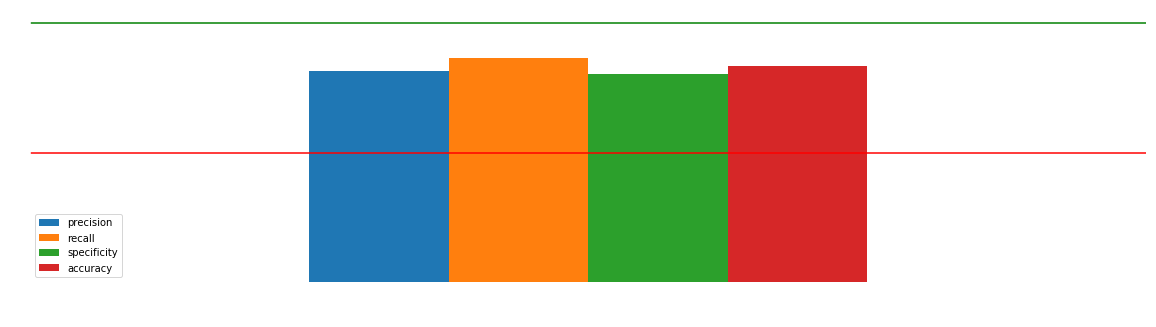

In [17]:
_= xai.metrics_imbalance(
        x_test, 
        y_test, 
        probabilities)

/home/alejandro/anaconda3/lib/python3.6/site-packages/xai-0.0.3-py3.6.egg/xai/__init__.py:520: RuntimeWarning: invalid value encountered in long_scalars


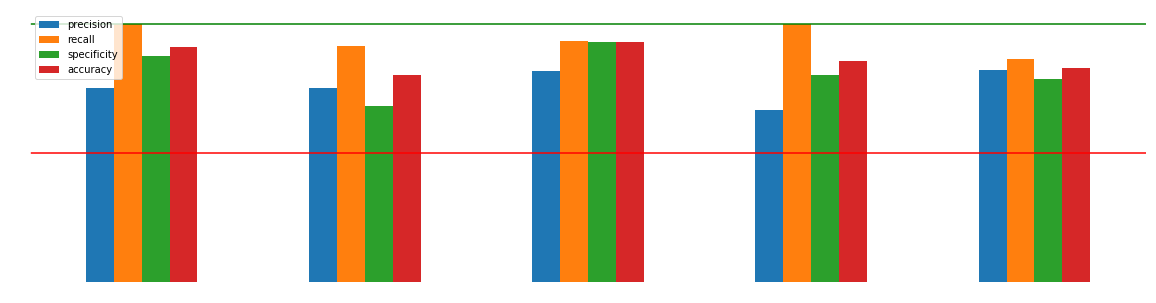

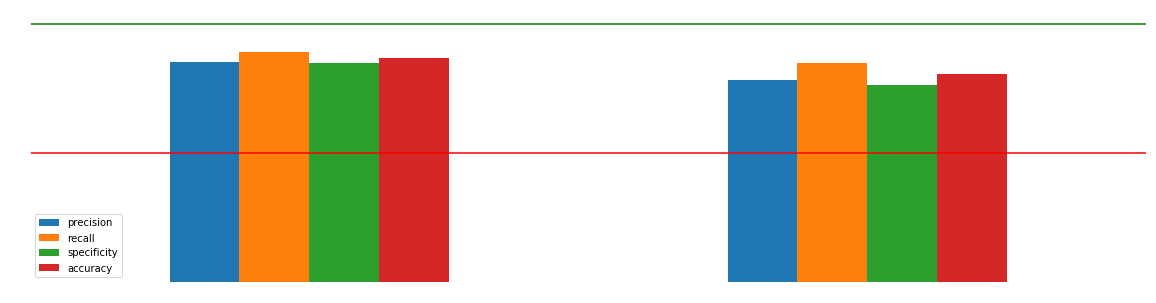

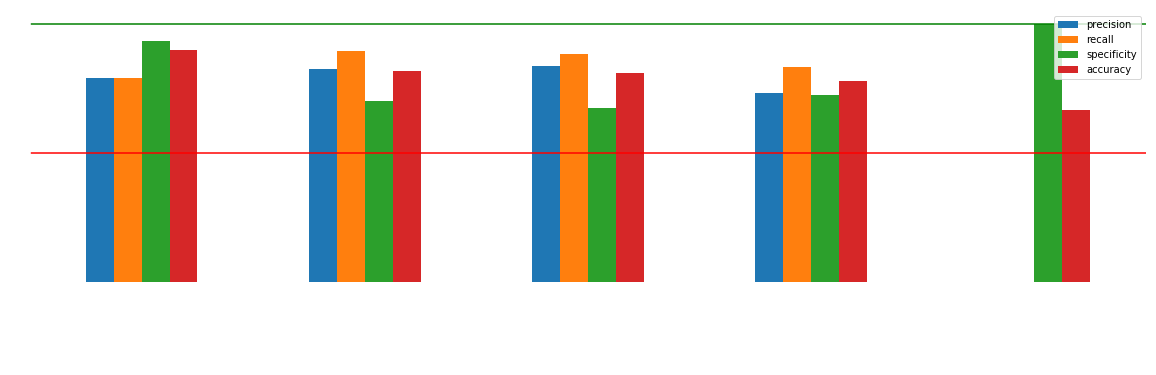

In [18]:
_= xai.metrics_imbalances(
        x_test, 
        y_test, 
        probabilities,
        columns=protected,
        categorical_cols=categorical_cols)

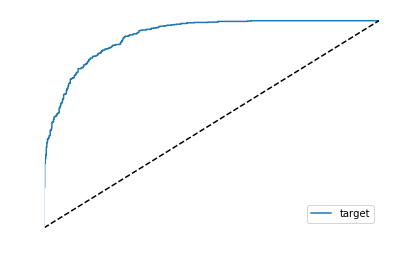

In [19]:
_= xai.roc_imbalance(
    x_test, 
    y_test, 
    probabilities)

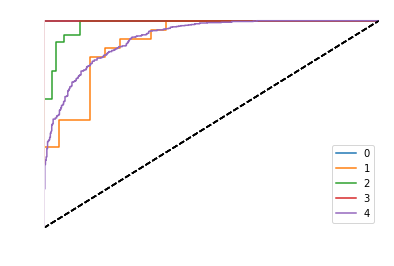

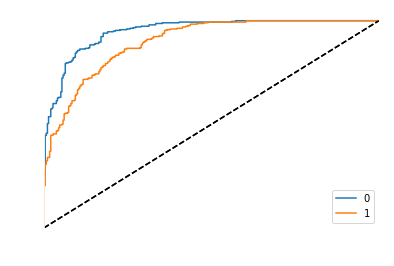

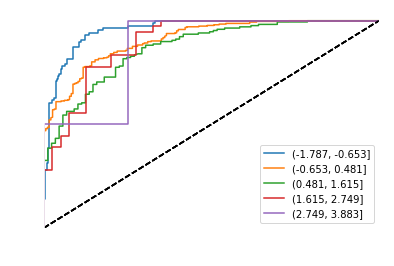

In [20]:
_= xai.roc_imbalances(
    x_test, 
    y_test, 
    probabilities, 
    columns=protected,
    categorical_cols=categorical_cols)

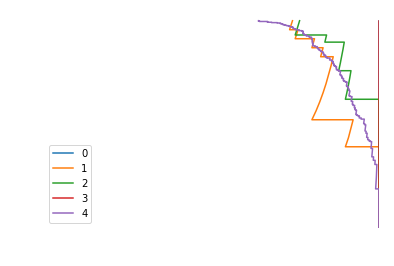

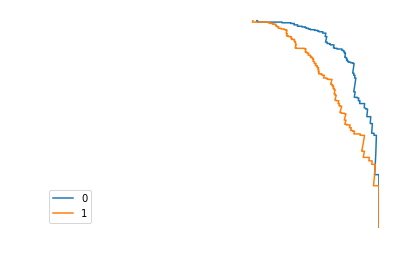

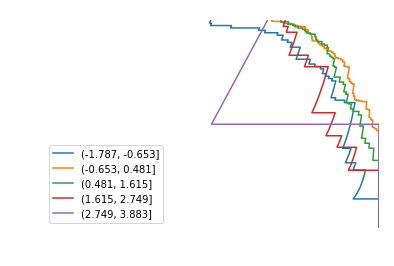

In [21]:
_= xai.pr_imbalances(
    x_test, 
    y_test, 
    probabilities, 
    columns=protected,
    categorical_cols=categorical_cols)

/home/alejandro/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


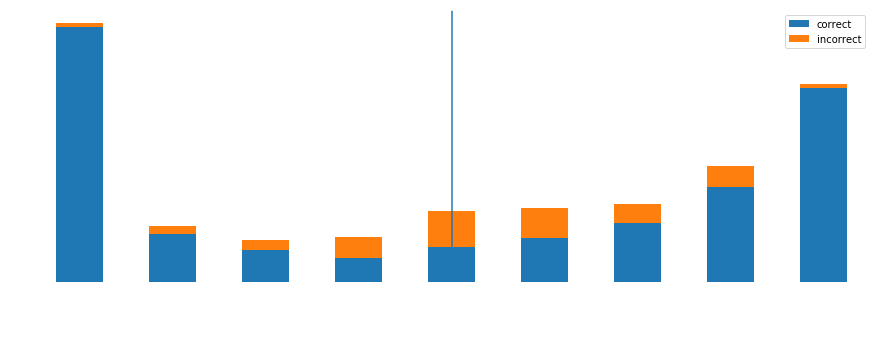

In [22]:
d = xai.smile_imbalance(
    y_test, 
    probabilities)

# d.sum()

/home/alejandro/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


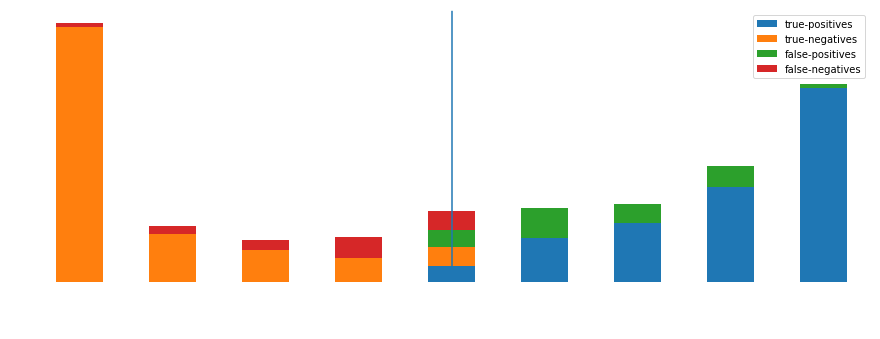

In [23]:
d = xai.smile_imbalance(
    y_test, 
    probabilities,
    display_breakdown=True)
# d.sum()

/home/alejandro/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


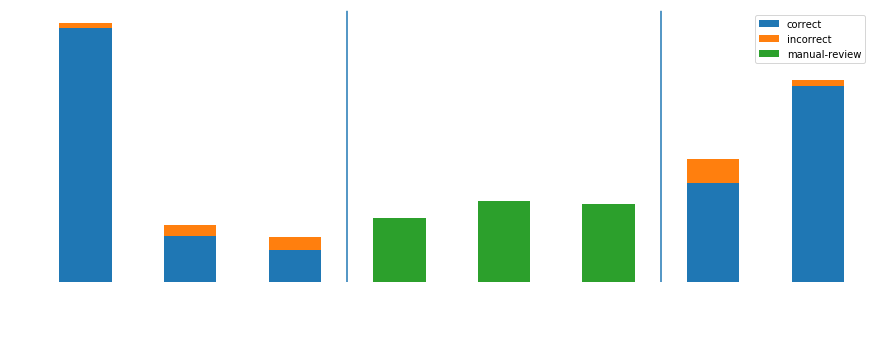

In [24]:
d = xai.smile_imbalance(
    y_test, 
    probabilities,
    bins=9,
    threshold=0.75,
    manual_review=0.375,
    display_breakdown=False)
# d.sum()

In [25]:
for c in x.columns: 
    print(c)

age
workclass
education
education-num
marital-status
occupation
relationship
ethnicity
gender
capital-gain
capital-loss
hours-per-week


,age,workclass,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week
0,0.028167,-0.0015,-0.00125,0.037,0.092333,0.0175,0.01975,0.002083,0.005917,0.044917,0.006917,0.01225


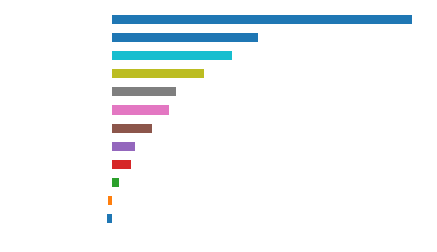

In [26]:
def get_avg(x, y):
    return model.evaluate(f_in(x), y, verbose=0)[1]

imp = xai.feature_importance(x_test, y_test, get_avg)

imp.head()